In [2]:


from __future__ import print_function, division

import matplotlib.pyplot as plt
import numpy as np
import pickle
import scipy.io as sio
import os
import seaborn as sns
from statannot import add_stat_annotation
import scipy.stats as stats
import pandas as pd

import sys
sys.path.append('../../')

from color_scripts import color_transforms as CT # scripts with a bunch of functions for color transformations
from error_measures_scripts import Error_measures as EM
from display_scripts import display as dis
from utils_scripts import algos


# Ignore warnings
import warnings

warnings.filterwarnings("ignore")


# In[2]:



In [3]:


def load_layer(path):
	import glob
	addrs = sorted(glob.glob(path + '/*.pickle'))
	LAYER = list()
	for addr in addrs:
		pickle_in = open(addr,'rb')
		layer = pickle.load(pickle_in, encoding='latin1')
		pickle_in.close()
		LAYER.extend(layer)
	return np.array(LAYER)


# In[9]: path to files

txt_dir_path = '../../txt_files/'
npy_dir_path = '../../npy_files/'
pickles_dir_path = '../pickles/'
figures_dir_path = '../figures/'

# In[9]: load mnodels results


def from330to8x40(X):
    '''
    Function to convert from array with one munsell dimension of 330 to an array with 2 dimensions (10,41),
    corresponding to the WCS coordinates
    Parameters:
        - X: array of shape = [...,330,...]
    Returns:
        - WCS_MAT: array of shape = [...,10,41,...] foolowing the WCS coordinates
    '''

    # List of WCS coordinates
    L = list()
    with open(txt_dir_path +"WCS_indx.txt") as f:
        for line in f:
           L.append(line.split())

    WCS_X = [ord(char[0][0].lower()) - 97 for char in L]
    WCS_Y = [int(char[0][1:]) for char in L]

    # identification of dim with size 330
    idx = np.array(X).shape.index(330)
    # move this dim to the first
    X = np.moveaxis(X,idx,0)
    # initialization of new array
    WCS_MAT = np.zeros(tuple([10,41]) + X.shape[1:])
    count = 0
    for i in range(330):
        WCS_MAT[WCS_X[i],WCS_Y[i]] = X[count].astype(float)
        count +=1
    return np.moveaxis(WCS_MAT,(0,1),(idx,idx+1)) # move dimensions in the right order

def load_pickle(path):
    import pickle
    f = open(path,"rb")
    return pickle.load(f, fix_imports=True, encoding='latin1', errors="strict")



In [4]:

# In[9]: LOAD ERROR MEASURES

measures = ['Accu', 'Accu5', 'Accu_munscube', 'DE', 'CCI', 'DE_3D']

conditions = ['normal','no_patch', 'wrong_illu', 'no_back', 'D65']

SofA_models = ['MobileNet', 'VGG11_bn', 'ResNet50','RefResNet']

layers = ['fc2','fc1', 'c3', 'c2', 'c1']


ERRORS = {}
Errors_D65_D65 = {}


path = pickles_dir_path

## RefConvNet errors
for layer in layers:
    ERRORS[layer] = {}
    for condition in conditions[:-1]:
        ERRORS[layer][condition] = load_pickle(path + 'Errors_Original_CC_4illu_WCS_%s_%s.pickle'%(layer, condition))
    ERRORS[layer][conditions[-1]] = load_pickle(path + 'Errors_Original_D65_4illu_WCS_%s_normal.pickle'%(layer))
    Errors_D65_D65[layer] = load_pickle(path + 'Errors_Original_D65_D65_WCS_%s_normal.pickle'%(layer))

ERRORS_SofA = {}
for model in ( SofA_models):
        ERRORS_SofA[model] = {}
        for condition in conditions[0:-1]:
                ERRORS_SofA[model][condition] = load_pickle(path +  'Errors_%s_CC_5illu_WCS__%s.pickle'%(model, condition))

DICT_ERRORS = {}
for model in ( SofA_models + ['RefConvNet']):
        DICT_ERRORS[model] = {}
        for condition in conditions[2:-1]:
                DICT_ERRORS[model][condition] = {}
                for measure in measures:
                        DICT_ERRORS[model][condition][measure] = {}
                        if measure == 'CCI':
                                if model == 'RefConvNet':
                                        DICT_ERRORS[model][condition][measure] = np.round(np.median(ERRORS['fc2'][condition][measure]),2)
                                else:
                                        DICT_ERRORS[model][condition][measure] = np.round(np.median(ERRORS_SofA[model][condition][measure]),2)
                        else:
                                if model == 'RefConvNet':
                                        DICT_ERRORS[model][condition][measure] = np.round(np.mean(ERRORS['fc2'][condition][measure]),2)
                                else:
                                        DICT_ERRORS[model][condition][measure] = np.round(np.mean(ERRORS_SofA[model][condition][measure]),2)

df = pd.DataFrame.from_dict({(i,j): DICT_ERRORS[i][j] 
                           for i in DICT_ERRORS.keys() 
                           for j in DICT_ERRORS[i].keys()},
                       orient='columns')
df.to_csv(path_or_buf ='ERRORS_all.csv')


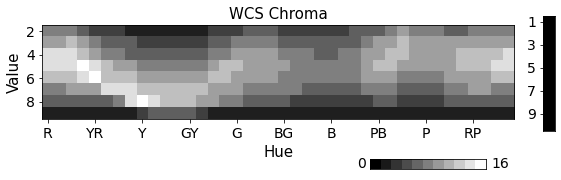

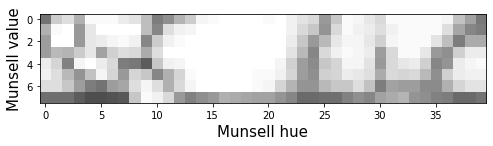

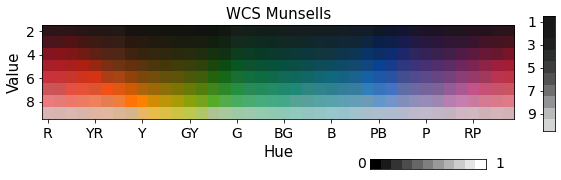

In [5]:

CHROMA = list()
with open(txt_dir_path +"WCS_chroma.txt") as f:
    for line in f:
       CHROMA.append(int(line.split()[0]))


WCS_MAT_CHROMA = from330to8x40(CHROMA)
dis.display_munsells_inv(WCS_MAT_CHROMA,16,'WCS Chroma', save = True, add = figures_dir_path + 'WCS_chroma.png')


mat_speakers = sio.loadmat(npy_dir_path +'matrix_WCS_speakers.mat')['WCS_speakers']


mat_consistency = sio.loadmat(npy_dir_path +'consistency_map4Alban.mat')['cmap']
#dis.display_munsells_inv(mat_consistency,1)

mat_consistency2 = np.zeros(mat_consistency.shape)
for i in range(len(mat_consistency2)):
    mat_consistency2[i] = mat_consistency[7-i]
#dis.display_munsells_inv(mat_consistency2,1)

general_mat_consistency = sio.loadmat(npy_dir_path +'general_consensusconsistency_map4Alban.mat')['cmap_general']
general_mat_consistency2 = np.zeros(general_mat_consistency.shape)
for i in range(len(general_mat_consistency2)):
    general_mat_consistency2[i] = general_mat_consistency[7-i]
dis.display_munsells(general_mat_consistency2[0:-3],1)


with open(txt_dir_path +"XYZ_WCS.txt", "rb") as fp:   #Pickling
    XYZ_WCS = pickle.load(fp, encoding='latin1')

RGB_muns = [CT.XYZ2sRGB(XYZ) for XYZ in XYZ_WCS]
WCS_MAT_RGB =from330to8x40(RGB_muns)

WCS_MAT_sRGB = (WCS_MAT_RGB - np.amin(WCS_MAT_RGB))/(np.amax(WCS_MAT_RGB)-np.amin(WCS_MAT_RGB))
RGB_muns = (RGB_muns - np.amin(RGB_muns))/(np.amax(RGB_muns)-np.amin(RGB_muns))

dis.display_munsells_inv(WCS_MAT_sRGB,1,'WCS Munsells', save = True, add = figures_dir_path + 'WCS_RGB.png')


nb_mod = ERRORS[layers[0]][conditions[0]]['DE'].shape[0]
nb_obj = ERRORS[layers[0]][conditions[0]]['DE'].shape[1]

Average Delta E value per illuminations:
[1.63114502 1.89763836 2.2238542  2.72315255]
Average Delta E value for D65:
[1.10193628]


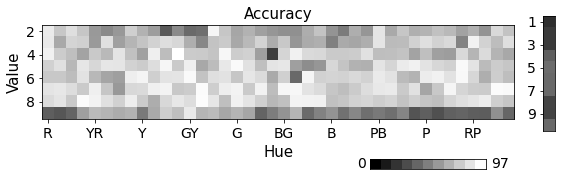

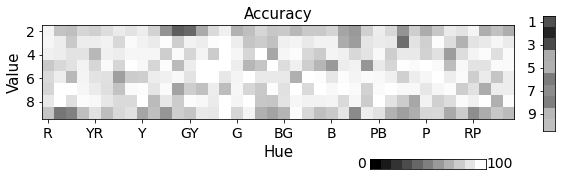

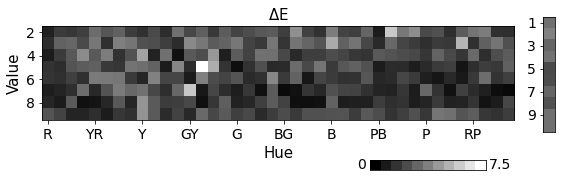

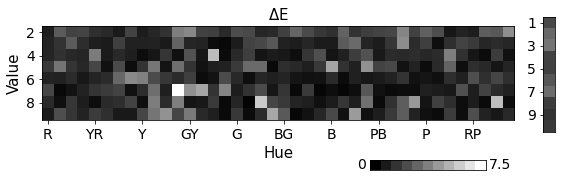

In [6]:


# In[9]: Compute accuracy as a measure of LAB delta E

# CIELab coordinates of WCS muns under YBGR illuminants
WCS_LAB_4 = np.load(npy_dir_path +'LAB_WCS_ABCD.npy')

MUNS_LAB_4 = np.moveaxis(np.load(npy_dir_path +'LAB_MUNS_ABCD.npy'),0,-1)

MUNSELL_LAB = np.load(npy_dir_path +'MUNSELL_LAB.npy')

MUNS_neighbouring_dist = np.load(npy_dir_path + 'MUNS_neighbouring_dist.npy')
WCS_neighbouring_dist = MUNS_neighbouring_dist[algos.compute_WCS_Munsells_categories()]

DE_illu = np.mean(ERRORS[layers[0]][conditions[0]]['DE'],axis = (0,1,-1))
DE_muns = np.mean(ERRORS[layers[0]][conditions[0]]['DE'],axis = (0,-2,-1))
print('Average Delta E value per illuminations:')
print(DE_illu)

DE_D65 = np.mean(Errors_D65_D65[layers[0]]['DE'],axis = (0,1,-1))
print('Average Delta E value for D65:')
print(DE_D65)


DE_MAT = from330to8x40(np.mean(ERRORS[layers[0]][conditions[0]]['DE'],axis = (-1,-2)))
DE_MAT_ResNet = from330to8x40(np.mean(ERRORS_SofA['RefResNet'][conditions[0]]['DE'],axis = (-1,-2)))
DE_MAT_D65 = from330to8x40(np.mean(Errors_D65_D65[layers[0]]['DE'],axis = (-1,-2)))
DIST_neighbours_MAT = from330to8x40(WCS_neighbouring_dist)

normalized_DELTAE = np.mean(DE_MAT, axis = 0)/DIST_neighbours_MAT
normalized_DELTAE[np.mean(DE_MAT, axis = 0) == 0] = 0

Accu_MAT = from330to8x40(ERRORS[layers[0]][conditions[0]]['Accu'])
Accu_MAT_ResNet = from330to8x40(ERRORS_SofA['RefResNet'][conditions[0]]['Accu'])

dis.display_munsells_inv(np.mean(Accu_MAT,axis = (0,-1)), np.amax(np.mean(Accu_MAT,axis = (0,-1))), 'Accuracy')
dis.display_munsells_inv(np.mean(Accu_MAT_ResNet,axis = (0,-1)), np.amax(np.mean(Accu_MAT_ResNet,axis = (0,-1))), 'Accuracy')

dis.display_munsells_inv(np.mean(DE_MAT,axis = 0), np.amax(np.mean(DE_MAT,axis = 0)), '$\Delta$E')
dis.display_munsells_inv(np.mean(DE_MAT_ResNet,axis = 0), np.amax(np.mean(DE_MAT_ResNet,axis = 0)), '$\Delta$E')



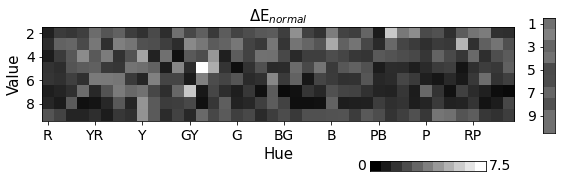

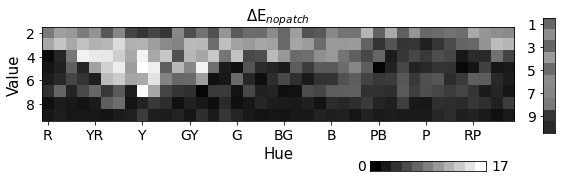

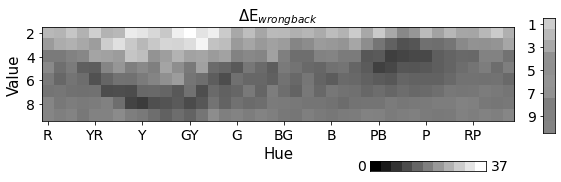

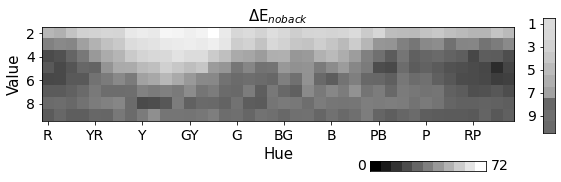

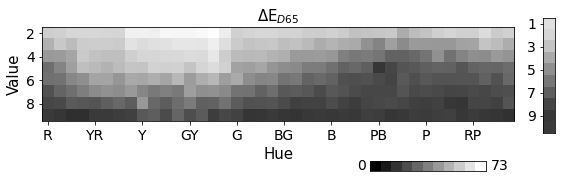

In [7]:

DE_MAT_normal = DE_MAT
DE_MAT_nopatch =  from330to8x40(np.mean(ERRORS[layers[0]][conditions[1]]['DE'],axis = (-1,-2)))
DE_MAT_wrongback =  from330to8x40(np.mean(ERRORS[layers[0]][conditions[2]]['DE'],axis = (-1,-2)))
DE_MAT_noback =  from330to8x40(np.mean(ERRORS[layers[0]][conditions[3]]['DE'],axis = (-1,-2)))
DE_MAT_D65D65 =  from330to8x40(np.mean(ERRORS[layers[0]][conditions[-1]]['DE'],axis = (-1,-2)))

dis.display_munsells_inv(np.mean(DE_MAT_normal,axis = 0), np.amax(np.mean(DE_MAT_normal,axis = 0)), '$\Delta$E$_{normal}$', save = True, add = figures_dir_path + '$\Delta$E$_{normal}$.png')
dis.display_munsells_inv(np.mean(DE_MAT_nopatch,axis = 0), np.amax(np.mean(DE_MAT_nopatch,axis = 0)), '$\Delta$E$_{nopatch}$', save = True, add = figures_dir_path + '$\Delta$E$_{nopatch}$')
dis.display_munsells_inv(np.mean(DE_MAT_wrongback,axis = 0), np.amax(np.mean(DE_MAT_wrongback,axis = 0)), '$\Delta$E$_{wrongback}$', save = True,add = figures_dir_path + '$\Delta$E$_{wrongback}$')
dis.display_munsells_inv(np.mean(DE_MAT_noback,axis = 0), np.amax(np.mean(DE_MAT_noback,axis = 0)), '$\Delta$E$_{noback}$', save = True, add = figures_dir_path + '$\Delta$E$_{noback}$')
dis.display_munsells_inv(np.mean(DE_MAT_D65D65,axis = 0), np.amax(np.mean(DE_MAT_D65D65,axis = 0)), '$\Delta$E$_{D65}$', save = True, add = figures_dir_path + '$\Delta$E$_{D65}$')


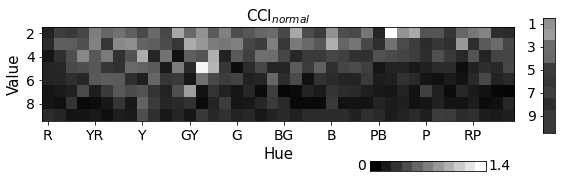

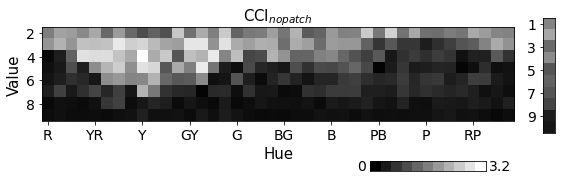

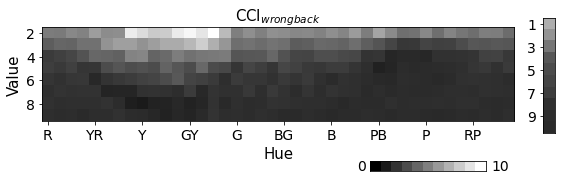

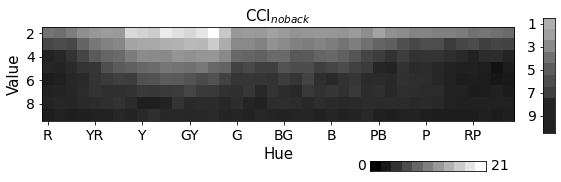

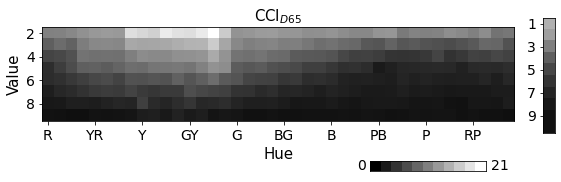

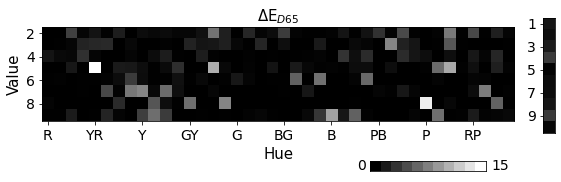

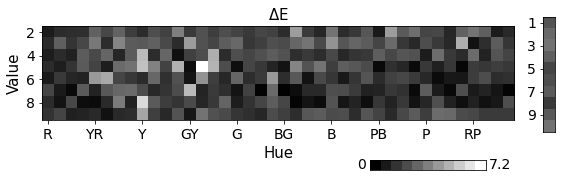

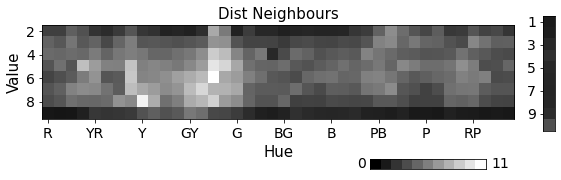

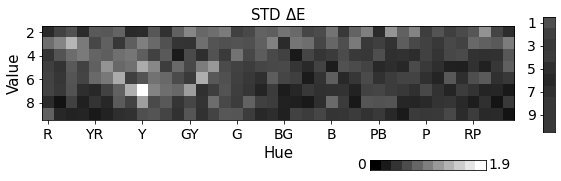

In [8]:

CCI_MAT_normal = from330to8x40(np.mean(ERRORS[layers[0]][conditions[0]]['CCI'],axis = (1,-1)))
CCI_MAT_nopatch =  from330to8x40(np.mean(ERRORS[layers[0]][conditions[1]]['CCI'],axis = (-1,1)))
CCI_MAT_wrongback =  from330to8x40(np.mean(ERRORS[layers[0]][conditions[2]]['CCI'],axis = (-1,1)))
CCI_MAT_noback =  from330to8x40(np.mean(ERRORS[layers[0]][conditions[3]]['CCI'],axis = (-1,1)))
CCI_MAT_D65D65 =  from330to8x40(np.mean(ERRORS[layers[0]][conditions[-1]]['CCI'],axis = (-1,1)))

dis.display_munsells_inv(1-np.mean(CCI_MAT_normal,axis = 0), np.amax(1-np.mean(CCI_MAT_normal,axis = 0)), 'CCI$_{normal}$',  save = True, add = figures_dir_path + 'CCI$_{normal}$.png')
dis.display_munsells_inv(1-np.mean(CCI_MAT_nopatch,axis = 0), np.amax(1-np.mean(CCI_MAT_nopatch,axis = 0)), 'CCI$_{nopatch}$',  save = True, add = figures_dir_path + 'CCI$_{nopatch}$.png')
dis.display_munsells_inv(1-np.mean(CCI_MAT_wrongback,axis = 0), np.amax(1-np.mean(CCI_MAT_wrongback,axis = 0)), 'CCI$_{wrongback}$',  save = True, add = figures_dir_path + 'CCI$_{wrongback}$.png')
dis.display_munsells_inv(1-np.mean(CCI_MAT_noback,axis = 0), np.amax(1-np.mean(CCI_MAT_noback,axis = 0)), 'CCI$_{noback}$',  save = True, add = figures_dir_path + 'CCI$_{noback}$.png')
dis.display_munsells_inv(1-np.mean(CCI_MAT_D65D65,axis = 0), np.amax(1-np.mean(CCI_MAT_D65D65,axis = 0)), 'CCI$_{D65}$',  save = True, add = figures_dir_path + 'CCI$_{D65}$.png')

np.corrcoef(WCS_MAT_CHROMA[1:-1,1:].flatten(), np.mean(DE_MAT_nopatch,axis = 0)[1:-1,1:].flatten())

np.corrcoef(WCS_MAT_CHROMA[1:-1,1:].flatten(), np.mean(DE_MAT_wrongback,axis = 0)[1:-1,1:].flatten())
np.corrcoef(WCS_MAT_CHROMA[1:-1,1:].flatten(), 1-np.mean(CCI_MAT_wrongback,axis = 0)[1:-1,1:].flatten())
np.corrcoef(WCS_MAT_CHROMA[1:-1,1:].flatten(), np.mean(DE_MAT_noback,axis = 0)[1:-1,1:].flatten())
np.corrcoef(WCS_MAT_CHROMA[1:-1,1:].flatten(), 1-np.mean(CCI_MAT_noback,axis = 0)[1:-1,1:].flatten())
np.corrcoef(WCS_MAT_CHROMA[1:-1,1:].flatten(), np.mean(DE_MAT_D65D65,axis = 0)[1:-1,1:].flatten())
dis.display_munsells_inv(np.mean(DE_MAT_D65,axis = 0), np.amax(np.mean(DE_MAT_D65,axis = 0)), '$\Delta$E$_{D65}$')
dis.display_munsells_inv(DE_MAT[0], np.amax(DE_MAT[0]),'$\Delta$E')
dis.display_munsells_inv(DIST_neighbours_MAT, np.amax(DIST_neighbours_MAT),'Dist Neighbours')
#dis.display_munsells_inv(normalized_DELTAE,np.amax(normalized_DELTAE),'Normalize $\Delta$E')

# Comparison with consistency
dis.display_munsells_inv(np.std(DE_MAT,axis = 0), np.amax(np.std(DE_MAT,axis = 0)), 'STD $\Delta$E')
np.corrcoef(np.std(DE_MAT,axis = 0)[1:-1].flatten(), WCS_MAT_CHROMA[1:-1].flatten())

relative = np.std(DE_MAT,axis = 0)/np.mean(DE_MAT,axis = 0)
#dis.display_munsells_inv(relative, np.nanmax(relative))



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


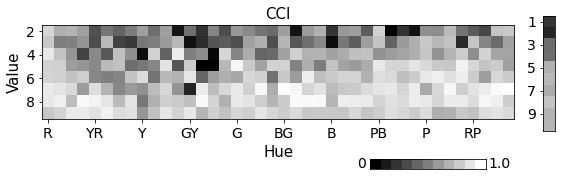

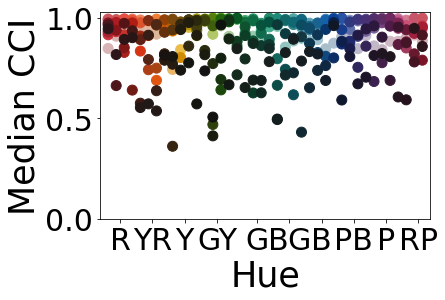

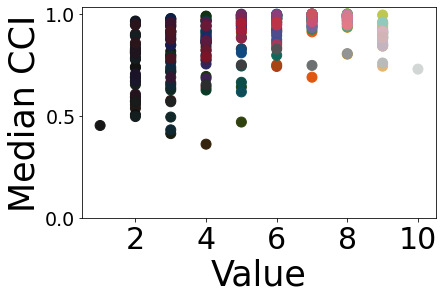

0.5705845171400039

In [9]:

# In[9]: COLOR CONSTANCY INDEX


CCI_MAT = from330to8x40(ERRORS[layers[0]][conditions[0]]['CCI'])
dis.display_munsells_inv(np.mean(CCI_MAT,axis = (0,1,-1)), np.nanmax(np.mean(CCI_MAT,axis = (0,1,-1))),'CCI')

### Some stats

CCI_MAT_chrom = np.median(CCI_MAT, axis = (0,1,-1))[1:-1,1:]
CCI_MAT_achrom = np.median(CCI_MAT, axis = (0,1,-1))[:,0]

dis.DEFINE_PLT_RC(type = 0.5)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(list(range(40))*8,CCI_MAT_chrom.flatten(),color = WCS_MAT_sRGB[1:-1,1:].reshape(-1,3),marker = '.',s = 400)
ax1.set_xlabel('Hue')
ax1.set_xticks([1.5,5.5,9.5,13.5,18.5,22.5,26.5,30.5,34.5,38.5])
ax1.set_xticklabels(['R','YR','Y','GY','G','BG','B','PB','P','RP'])

plt.yticks(np.arange(0,1.1,0.5))
plt.xlim(-1,40)
ax1.set_ylabel('Median CCI')
fig.tight_layout()
fig.savefig(figures_dir_path +'CCI_vs_hue.png', dpi=400)
plt.show()

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(list(range(9,1,-1))*40,CCI_MAT_chrom.T.flatten(),color = np.moveaxis(WCS_MAT_sRGB[1:-1,1:],1,0).reshape(-1,3),marker = '.',s = 400)
ax1.scatter(range(10,0,-1),CCI_MAT_achrom,color = WCS_MAT_sRGB[:,0],marker = '.',s = 400)
ax1.set_xlabel('Value')
ax1.set_xticks(range(0,11,2))
#ax1.set_xticklabels(['R','YR','Y','GY','G','BG','B','PB','P','RP'])

plt.yticks(np.arange(0,1.1,0.5),fontsize = 19)
ax1.set_ylabel('Median CCI')
plt.xlim(0.5,10.5)
fig.tight_layout()
fig.savefig(figures_dir_path+'CCI_vs_value.png', dpi=400)
plt.show()


#certainty = np.moveaxis(np.amax(OUT_soft = LoadandComputeOutputs(path2activations, NetType, Testing_type, layer, testing_condition) # Load output of last layer,axis = -1),-1, 1)


np.median(ERRORS[layers[0]][conditions[0]]['CCI'])
np.median(ERRORS[layers[0]][conditions[0]]['DE'])
#np.mean(ERRORS[layers[0]][conditions[0]]['CCI'][certainty>0.25])



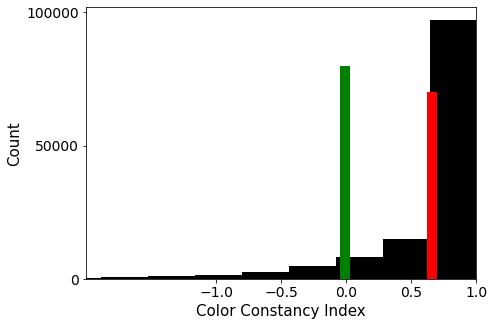

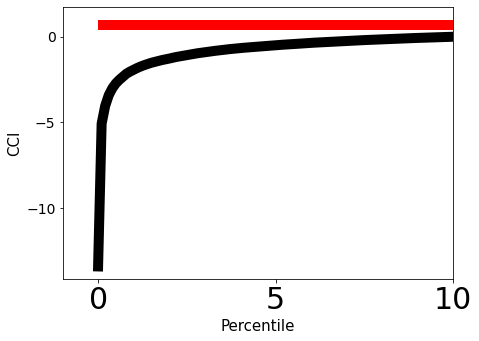

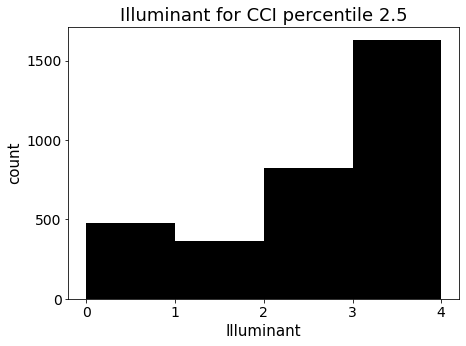

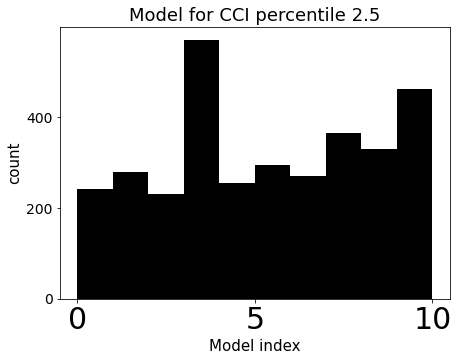

In [10]:

CCI_Y = ERRORS[layers[0]][conditions[0]]['CCI'][:,:,:,0]
CCI_B = ERRORS[layers[0]][conditions[0]]['CCI'][:,:,:,1]
CCI_G = ERRORS[layers[0]][conditions[0]]['CCI'][:,:,:,2]
CCI_R = ERRORS[layers[0]][conditions[0]]['CCI'][:,:,:,3]
np.median((CCI_Y,CCI_B,CCI_G, CCI_R))
np.median((CCI_Y,CCI_B))
np.median((CCI_G,CCI_R))

#np.mean((CCI_Y[certainty[:,:,:,0]>0.25],CCI_B[certainty[:,:,:,1]>0.25]))
#np.mean((CCI_G[certainty[:,:,:,2]>0.25],CCI_R[certainty[:,:,:,3]>0.25]))

np.median(ERRORS[layers[0]][conditions[0]]['CCI'])
np.amax(ERRORS[layers[0]][conditions[0]]['CCI'])
np.amin(ERRORS[layers[0]][conditions[0]]['CCI'])
np.percentile(ERRORS[layers[0]][conditions[0]]['CCI'],50)
#np.corrcoef(DE2.flatten(),ERRORS[layers[0]][conditions[0]]['CCI'])
#np.corrcoef(DE2.flatten(),certainty.flatten())
#np.corrcoef(certainty.flatten(),CCI.flatten())

### Distribution of CCI

fig = plt.figure()
plt.hist(ERRORS[layers[0]][conditions[0]]['CCI'].flatten(),bins = 40, color= 'black')
plt.vlines(np.nanmean(ERRORS[layers[0]][conditions[0]]['CCI']),ymin = 0, ymax = 70000,color = 'r')
#ax1.vlines(np.nanpercentile(1-p1,25),ymin = 0, ymax = 80000,color = 'orange')
plt.vlines(np.nanpercentile(ERRORS[layers[0]][conditions[0]]['CCI'],10),ymin = 0, ymax = 80000,color = 'g')
plt.xlabel('Color Constancy Index',fontsize = 15)
plt.ylabel('Count',fontsize = 15)
plt.xticks(np.arange(-1,1.1,0.5),fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlim(-2,1)

fig.tight_layout
plt.show()


fig = plt.figure()
perc = np.nanpercentile(ERRORS[layers[0]][conditions[0]]['CCI'],np.arange(0,100,0.1))
plt.plot(np.arange(0,100,0.1),perc, color= 'black')
plt.hlines(np.nanmean(perc),xmin = 0, xmax = 100,color = 'r')
plt.xlabel('Percentile',fontsize = 15)
plt.ylabel('CCI',fontsize = 15)
#plt.xticks(np.arange(0,101,25),fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlim(-1,10)

#fig.tight_layout
plt.show()


### FINDING OUT WHY SOME STIMULI LEAD TO SUCH BAD RESULTS

ARG = np.argwhere(ERRORS[layers[0]][conditions[0]]['CCI']<np.nanpercentile(ERRORS[layers[0]][conditions[0]]['CCI'],2.5))

fig = plt.figure()
p = plt.hist(ARG[:,-1],bins = range(0,5,1), color= 'black')
plt.xlabel('Illuminant',fontsize = 15)
plt.ylabel('count',fontsize = 15)
#plt.xticks(np.arange(0,101,25),fontsize = 14)
plt.yticks(fontsize = 14)
plt.xticks(range(5),fontsize = 14)
#plt.xlim(-1,10)
plt.title('Illuminant for CCI percentile 2.5',fontsize = 18)
#fig.savefig(figures_dir_path + 'Munsell_chips_WCS.png', dpi = 400)
fig.tight_layout
plt.show()


fig = plt.figure()
p = plt.hist(ARG[:,0],bins = range(0,11,1), color= 'black')
plt.xlabel('Model index',fontsize = 15)
plt.ylabel('count',fontsize = 15)
#plt.xticks(np.arange(0,101,25),fontsize = 14)
plt.yticks(fontsize = 14)
#plt.xlim(-1,10)
plt.title('Model for CCI percentile 2.5',fontsize = 18)
#fig.savefig('Munsell_chips_WCS.png')
fig.tight_layout
plt.show()


# In[9]: Comparison between conditions

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Y v.s. B: t-test paired samples with Bonferroni correction, P_val=1.281e-06 stat=1.286e+01
G v.s. R: t-test paired samples with Bonferroni correction, P_val=1.442e-02 stat=3.715e+00
B v.s. G: t-test paired samples with Bonferroni correction, P_val=4.737e-05 stat=8.344e+00


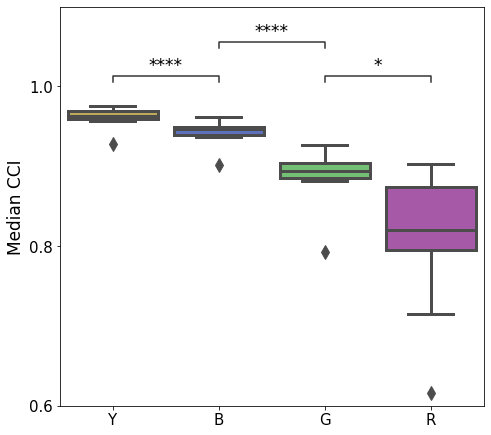

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Y v.s. B: t-test paired samples with Bonferroni correction, P_val=9.226e-03 stat=5.346e+00
G v.s. R: t-test paired samples with Bonferroni correction, P_val=1.371e-03 stat=8.130e+00
B v.s. G: t-test paired samples with Bonferroni correction, P_val=3.323e-04 stat=1.094e+01


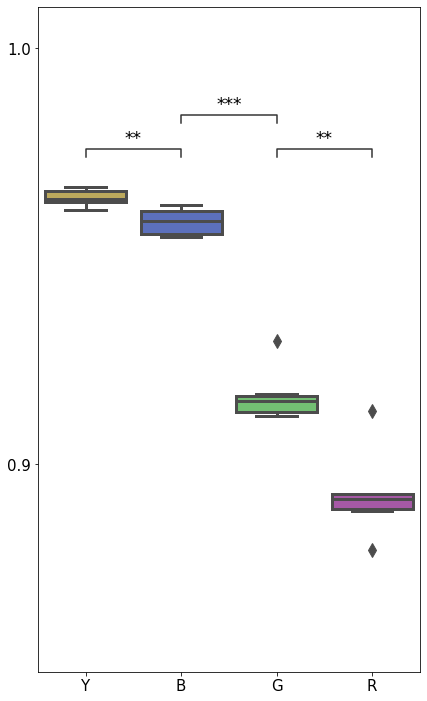

In [13]:


dis.DEFINE_PLT_RC(type = 1)

colors = [tuple([0.8,0.7,0.3]),tuple([0.3,0.4,0.8]),tuple([0.4,0.8,0.4]),tuple([0.7,0.3,0.7])]
#colors = ['o','b','g','m']

### Figures bbox for the effect of the illumination on the Color constancy Index

#ax = stats.ttest_rel(np.nanmedian(CCI_Y, axis = (1,2)), np.nanmedian(CCI_B, axis = (1,2)))

DICT_CCI = {}
DICT_CCI['Y'],DICT_CCI['B'], DICT_CCI['G'],DICT_CCI['R'] = np.nanmedian(CCI_Y, axis = (1,2)), np.nanmedian(CCI_B, axis = (1,2)), np.nanmedian(CCI_G, axis = (1,2)), np.nanmedian(CCI_R, axis = (1,2)) 
dat = pd.DataFrame(DICT_CCI)

fig = plt.figure(figsize = (7,6))
ax = sns.boxplot( data = dat , linewidth = 3, palette = colors, width = 0.85, fliersize = 10)
test_results = add_stat_annotation(ax, data=dat,
                                   box_pairs=[('Y', 'B'), ('G', 'R'), ('B', 'G')],
                                   test='t-test_paired', text_format='star',
                                   loc='outside', verbose=2)
ax.set_yticks([0.6,0.8,1])
ax.set_ylabel('Median CCI')
plt.ylim(0.6,1.1)
#plt.title('ConvNet')
fig.subplots_adjust(top=0.973,bottom=0.049,left=0.114,right=0.955,hspace=0.2,wspace=0.2)
fig.savefig(figures_dir_path +'ConvNet_median_YBGR.png', dpi=400)
plt.show()


CCI_ResNet = ERRORS_SofA['RefResNet'][conditions[0]]['CCI']
DICT_CCI = {}
DICT_CCI['Y'],DICT_CCI['B'], DICT_CCI['G'],DICT_CCI['R'] = np.nanmedian(CCI_ResNet[:,:,:,0], axis = (1,2)), np.nanmedian(CCI_ResNet[:,:,:,1], axis = (1,2)), np.nanmedian(CCI_ResNet[:,:,:,2], axis = (1,2)), np.nanmedian(CCI_ResNet[:,:,:,3], axis = (1,2)) 
dat = pd.DataFrame(DICT_CCI)

fig = plt.figure(figsize = (6.5,10))
ax = sns.boxplot( data = dat , linewidth = 3, palette = colors, width = 0.85, fliersize = 10)
test_results = add_stat_annotation(ax, data=dat,
                                   box_pairs=[('Y', 'B'), ('G', 'R'), ('B', 'G')],
                                   test='t-test_paired', text_format='star',
                                   loc='outside', verbose=2)
ax.set_yticks([0.9,1])
#ax.set_ylabel('Median CCI')
plt.ylim(0.85,1.01)
#plt.title('ResNet')
fig.subplots_adjust(top=0.973,bottom=0.049,left=0.139,right=0.955,hspace=0.2,wspace=0.2)
fig.savefig(figures_dir_path +'ResNet_median_YBGR.png', dpi=400)
plt.show()



In [23]:

# In[9]: Comparison between conditions


def closest_idx(vect, list_vect):
    return np.argmin(np.linalg.norm(list_vect - vect, axis = -1))

def fct_predicted_errors(WCS_LAB_4, MUNSELL_LAB, MUNS_LAB_4, wcs_idx, illu):
    '''
    Arguments:
        WCS_LAB_4: array of WCS munsells' chromaticities under 4 illuminants. dim = [4,330,3]
        MUNSELL_LAB: array of munsell chips chromaticities under D65. dim = [1600, 3]
        MUNS_LAB_4: array of munsell chips chromaticities under 4 illuminants. dim = [1600, 4, 3]
        WCS_idx: WCS index of the munsell for which to compute errors
        illu: illuminant index
    '''
    list_WCS_labels = algos.compute_WCS_Munsells_categories()
    predicted_idx = closest_idx(WCS_LAB_4[illu, wcs_idx], MUNSELL_LAB)
    de_predicted = np.linalg.norm(MUNS_LAB_4[predicted_idx, illu] - WCS_LAB_4[illu,wcs_idx])
    de_shifted = np.linalg.norm(WCS_LAB_4[illu, wcs_idx] - MUNSELL_LAB[list_WCS_labels[wcs_idx]])
    cci = 1 - de_predicted / de_shifted
    return (predicted_idx == list_WCS_labels[wcs_idx])*1, de_predicted, cci

def full_predicted_errors(WCS_LAB_4, MUNSELL_LAB, MUNS_LAB_4):
    '''
    Arguments:
        WCS_LAB_4: array of WCS munsells' chromaticities under 4 illuminants. dim = [4,330,3]
        MUNSELL_LAB: array of munsell chips chromaticities under D65. dim = [1600, 3]
        MUNS_LAB_4: array of munsell chips chromaticities under 4 illuminants. dim = [1600, 4, 3]
    '''
    ERROR = np.zeros((len(WCS_LAB_4), len(WCS_LAB_4[0]), 3))
    for illu in range(len(WCS_LAB_4)):
        for wcs_idx in range(len(WCS_LAB_4[illu])):
            ERROR[illu, wcs_idx] = fct_predicted_errors(WCS_LAB_4, MUNSELL_LAB, MUNS_LAB_4, wcs_idx, illu)
    return {'Accu': 100*np.sum(ERROR[:,:,0], axis = (1))/ERROR.shape[1], 'DE': np.median(ERROR[:,:,1], axis = 1), 'CCI': np.median(ERROR[:,:,2], axis = 1)}

#WCS_LAB_4
#MUNS_LAB_4
#MUNSELL_LAB


In [24]:

predicted_errors = full_predicted_errors(WCS_LAB_4.T, MUNSELL_LAB, MUNS_LAB_4 )

#list_WCS_labels = algos.compute_WCS_Munsells_categories() # import idxes of WCS munsells among the 1600

CCI_normal = np.array([np.median(ERRORS[layer]['normal']['CCI'], axis = (1,2,3)) for layer in layers[::-1]])
DE_normal = np.array([np.median(ERRORS[layer]['normal']['DE'], axis = (1,2,3)) for layer in layers[::-1]])
Accu_normal = np.array([np.mean(ERRORS[layer]['normal']['Accu'], axis = (1,2)) for layer in layers[::-1]])
Accu5_normal = np.array([np.mean(ERRORS[layer]['normal']['Accu5'], axis = (1,2)) for layer in layers[::-1]])
Accu_munscube_normal = np.array([np.mean(ERRORS[layer]['normal']['Accu_munscube'], axis = (1,2)) for layer in layers[::-1]])
#CCI_normal_bar = np.array([np.std(ERRORS[layer]['normal']['CCI']) for layer in layers])

CCI_no_patch = np.array([np.median(ERRORS[layer]['no_patch']['CCI'], axis = (1,2,3)) for layer in layers[::-1]])
DE_no_patch = np.array([np.median(ERRORS[layer]['no_patch']['DE'], axis = (1,2,3)) for layer in layers[::-1]])
Accu_no_patch = np.array([np.mean(ERRORS[layer]['no_patch']['Accu'], axis = (1,2)) for layer in layers[::-1]])
Accu5_no_patch = np.array([np.mean(ERRORS[layer]['no_patch']['Accu5'], axis = (1,2)) for layer in layers[::-1]])
Accu_munscube_no_patch = np.array([np.mean(ERRORS[layer]['no_patch']['Accu_munscube'], axis = (1,2)) for layer in layers[::-1]])
#CCI_no_patch = np.load(CC_dir_path +'training_centered/All_muns/CCI_fost_weighted_no_patch_std.npy')

CCI_no_back = np.array([np.median(ERRORS[layer]['no_back']['CCI'], axis = (1,2,3)) for layer in layers[::-1]])
DE_no_back = np.array([np.median(ERRORS[layer]['no_back']['DE'], axis = (1,2,3)) for layer in layers[::-1]])
Accu_no_back = np.array([np.mean(ERRORS[layer]['no_back']['Accu'], axis = (1,2)) for layer in layers[::-1]])
Accu5_no_back = np.array([np.mean(ERRORS[layer]['no_back']['Accu5'], axis = (1,2)) for layer in layers[::-1]])
Accu_munscube_no_back = np.array([np.mean(ERRORS[layer]['no_back']['Accu_munscube'], axis = (1,2)) for layer in layers[::-1]])
#CCI_no_back = np.load(CC_dir_path +'training_centered/WCS/finetuning/CCI_fost_weighted_no_back_std.npy')

CCI_wrong_illu = np.array([np.median(ERRORS[layer]['wrong_illu']['CCI'], axis = (1,2,3)) for layer in layers[::-1]])
DE_wrong_illu = np.array([np.median(ERRORS[layer]['wrong_illu']['DE'], axis = (1,2,3)) for layer in layers[::-1]])
Accu_wrong_illu = np.array([np.mean(ERRORS[layer]['wrong_illu']['Accu'], axis = (1,2)) for layer in layers[::-1]])
Accu5_wrong_illu = np.array([np.mean(ERRORS[layer]['wrong_illu']['Accu5'], axis = (1,2)) for layer in layers[::-1]])
Accu_munscube_wrong_illu = np.array([np.mean(ERRORS[layer]['wrong_illu']['Accu_munscube'], axis = (1,2)) for layer in layers[::-1]])
#CCI_wrong_illu = np.load(CC_dir_path +'training_centered/All_muns/CCI_fost_weighted_wrong_illu_std.npy')

CCI_D65 = np.array([np.nanmedian(ERRORS[layer]['D65']['CCI'], axis = (1,2,3)) for layer in layers[::-1]])
DE_D65 = np.array([np.nanmedian(ERRORS[layer]['D65']['DE'], axis = (1,2,3)) for layer in layers[::-1]])
Accu_D65 = np.array([np.nanmean(ERRORS[layer]['D65']['Accu'], axis = (1,2)) for layer in layers[::-1]])


### Classic color constancy for DE and CCI

DICT_ref = np.load('DICT_ref.npy',allow_pickle = True)[True][0]
DICT_vK = np.load('DICT_vK.npy',allow_pickle = True)[True][0]
DICT_noCC = np.load('DICT_noCC.npy',allow_pickle = True)[True][0]
DICT_CCC = np.load('DICT_CCC.npy',allow_pickle = True)[True][0]

        ###DE

LMS_4illu = np.array([[0.8608155 , 0.87445185, 0.77403174],[0.78124027, 0.84468902, 1.04376177], [0.87937024, 0.95460385, 0.97006115],[0.77854056, 0.79059459, 0.86517277]])

DE_vK = np.linalg.norm(np.moveaxis(DICT_vK['LAB'],0,-2) - DICT_ref['LAB'][:,0,0], axis = 2)
error_vK = np.median(DE_vK)

DE_noCC = np.linalg.norm(np.moveaxis(DICT_noCC['LAB'],0,-2) - DICT_ref['LAB'][:,0,0], axis = 2)
error_noCC = np.median(DE_noCC)

DE_GW = np.linalg.norm(DICT_CCC['LAB'][:,0,:] - DICT_ref['LAB'][:,0], axis = 0)
error_GW = np.median(DE_GW)

DE_WP = np.linalg.norm(DICT_CCC['LAB'][:,1] - DICT_ref['LAB'][:,0], axis = 0)
error_WP = np.median(DE_WP)

### We ignored edges cause they performed very badly
error_edge1 = np.mean(np.linalg.norm(DICT_CCC['LAB'][:,2] - DICT_ref['LAB'][:,0], axis = 0))
error_edge2 = np.mean(np.linalg.norm(DICT_CCC['LAB'][:,3] - DICT_ref['LAB'][:,0], axis = 0))

DE_contrast = np.linalg.norm(DICT_CCC['LAB'][:,4] - DICT_ref['LAB'][:,0], axis = 0)
error_contrast = np.median(DE_contrast)

        #CCI

CCI_noCC = np.median(1 - DE_noCC/DE_noCC)
CCI_vK = np.median(1 - DE_vK/DE_noCC)
CCI_GW = np.median(1 - DE_GW/DE_noCC)
CCI_WP = np.median(1 - DE_WP/DE_noCC)
CCI_contrast = np.median(1 - DE_contrast/DE_noCC)


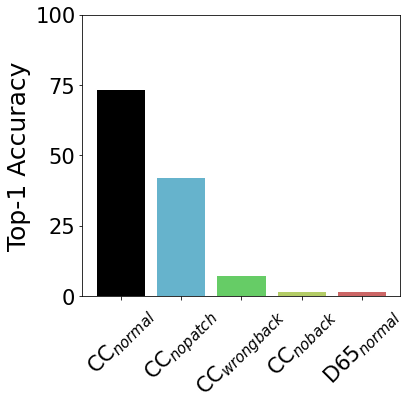

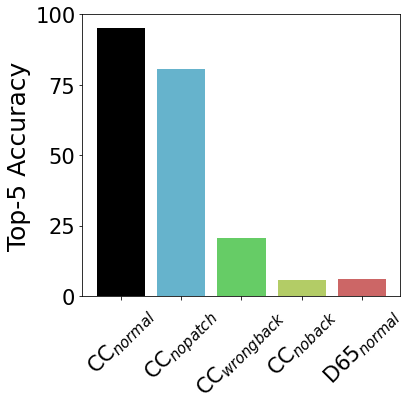

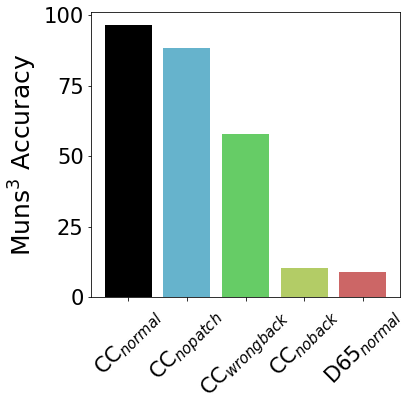

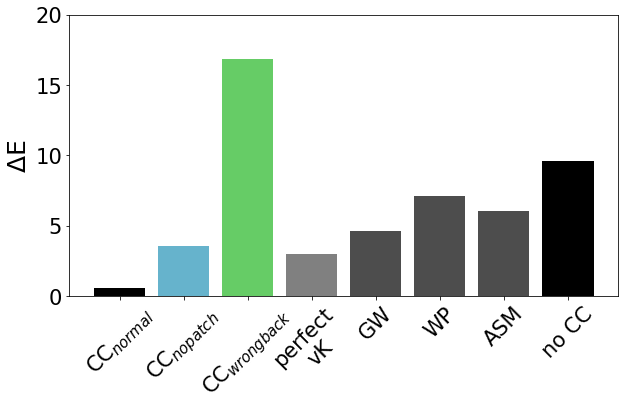

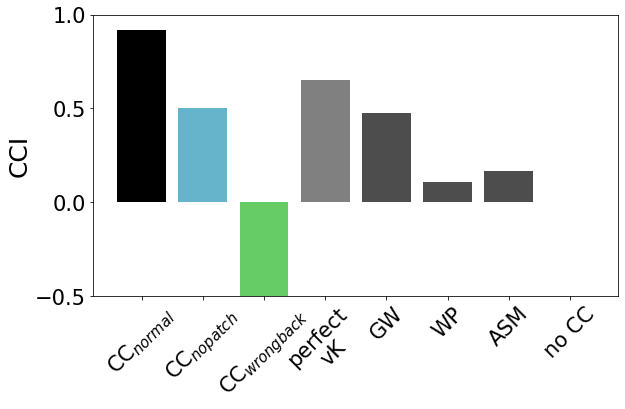

In [25]:

fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.bar([1,2,3,4,5],[np.mean(Accu_normal, axis = -1)[-1], np.mean(Accu_no_patch,axis = -1)[-1], np.mean(Accu_wrong_illu, axis = -1)[-1], np.mean(Accu_no_back, axis = -1)[-1], np.mean(Accu_D65, axis = -1)[-1]], color = ['k',[0.4,0.7,0.8],[0.4,0.8,0.4],[0.7,0.8,0.4],[0.8,0.4,0.4]],linewidth = 6)
ax1.set_xticks([1,2,3,4,5])
ax1.set_xticklabels([])
plt.xticks(fontsize = 21)
#plt.yticks(fontsize = 14)
plt.yticks(np.arange(0,105,25),fontsize = 21)
ax1.set_ylabel('Top-1 Accuracy',fontsize = 25)
ax1.set_xticklabels(['CC$_{normal}$','CC$_{no patch}$','CC$_{wrong back}$','CC$_{no back}$','D65$_{normal}$'], rotation = 45)
fig.tight_layout()
fig.savefig(figures_dir_path + 'Accuracy.png', dpi=400)
plt.show()



fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.bar([1,2,3,4,5],[np.mean(Accu5_normal, axis = -1)[-1], np.mean(Accu5_no_patch,axis = -1)[-1], np.mean(Accu5_wrong_illu, axis = -1)[-1], np.mean(Accu5_no_back, axis = -1)[-1], 6], color = ['k',[0.4,0.7,0.8],[0.4,0.8,0.4],[0.7,0.8,0.4],[0.8,0.4,0.4]],linewidth = 6)
ax1.set_xticks([1,2,3,4,5])
ax1.set_xticklabels([])
plt.xticks(fontsize = 21)
#plt.yticks(fontsize = 14)
plt.yticks(np.arange(0,105,25),fontsize = 21)
ax1.set_ylabel('Top-5 Accuracy',fontsize = 25)
ax1.set_xticklabels(['CC$_{normal}$','CC$_{no patch}$','CC$_{wrong back}$','CC$_{no back}$','D65$_{normal}$'], rotation = 45)
fig.tight_layout()
fig.savefig(figures_dir_path + 'Accuracy5.png', dpi=400)
plt.show()



fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.bar([1,2,3,4,5],[np.mean(Accu_munscube_normal, axis = -1)[-1], np.mean(Accu_munscube_no_patch,axis = -1)[-1], np.mean(Accu_munscube_wrong_illu, axis = -1)[-1], np.mean(Accu_munscube_no_back, axis = -1)[-1], 9], color = ['k',[0.4,0.7,0.8],[0.4,0.8,0.4],[0.7,0.8,0.4],[0.8,0.4,0.4]],linewidth = 6)
ax1.set_xticks([1,2,3,4,5])
ax1.set_xticklabels([])
plt.xticks(fontsize = 21)
#plt.yticks(fontsize = 14)
plt.yticks(np.arange(0,105,25),fontsize = 21)
ax1.set_ylabel('Muns$^3$ Accuracy',fontsize = 25)
ax1.set_xticklabels(['CC$_{normal}$','CC$_{no patch}$','CC$_{wrong back}$','CC$_{no back}$','D65$_{normal}$'], rotation = 45)
fig.tight_layout()
fig.savefig(figures_dir_path + 'Accuracy_munscube.png', dpi=400)
plt.show()



fig = plt.figure(figsize = (9,6))
ax1 = fig.add_subplot(111)
ax1.bar([1,2,3,4,5, 6, 7, 8], [np.mean(DE_normal, axis = -1)[-1], np.mean(DE_no_patch,axis = -1)[-1], np.mean(DE_wrong_illu, axis = -1)[-1], error_vK, error_GW, error_WP, error_contrast, error_noCC ],color = ['k',[0.4,0.7,0.8],[0.4,0.8,0.4],[0.5,0.5,0.5],[0.3,0.3,0.3],[0.3,0.3,0.3],[0.3,0.3,0.3],'k'],linewidth = 6)
ax1.set_xticks([1,2,3,4,5,  6, 7, 8])
ax1.set_xticklabels([])
plt.xticks(fontsize = 21)
ax1.set_xticklabels(['CC$_{normal}$','CC$_{no patch}$','CC$_{wrong back}$', 'perfect\nvK','GW','WP','ASM', 'no CC'], rotation = 45)
#plt.yticks(fontsize = 14)
plt.yticks(np.arange(0,21,5),fontsize = 21)
ax1.set_ylabel('$\Delta$E',fontsize = 25)
fig.tight_layout()
fig.savefig(figures_dir_path + 'DeltaE.png', dpi=600)
plt.show()



fig = plt.figure(figsize = (9,6))
ax1 = fig.add_subplot(111)
ax1.bar([1,2,3,4,5, 6, 7, 8], [np.mean(CCI_normal, axis = -1)[-1], np.mean(CCI_no_patch,axis = -1)[-1], np.mean(CCI_wrong_illu, axis = -1)[-1], CCI_vK, CCI_GW, CCI_WP, CCI_contrast, CCI_noCC + 0.001],color = ['k',[0.4,0.7,0.8],[0.4,0.8,0.4],[0.5,0.5,0.5],[0.3,0.3,0.3],[0.3,0.3,0.3],[0.3,0.3,0.3],'k'], linewidth = 6)
ax1.set_xticks([1,2,3,4,5,6, 7, 8])
ax1.set_xticklabels([])
plt.xticks(fontsize = 21)
ax1.set_xticklabels(['CC$_{normal}$','CC$_{no patch}$','CC$_{wrong back}$', 'perfect\nvK','GW','WP','ASM', 'no CC'], rotation = 45)
#plt.yticks(fontsize = 14)
plt.yticks(np.arange(-0.5,1.1,0.5),fontsize = 21)
ax1.set_ylabel('CCI',fontsize = 25)
plt.ylim(-0.5, 1)
fig.tight_layout()
fig.savefig(figures_dir_path + 'CCI.png', dpi=800)
plt.show()




In [72]:
print([np.mean(Accu_normal, axis = -1)[-1], np.mean(Accu_D65, axis = -1)[-1]])
print([np.mean(Accu5_normal, axis = -1)[-1], 6])
print([np.mean(Accu_munscube_normal, axis = -1)[-1], 9])
print([np.mean(Accu_no_patch, axis = -1)[-1], np.mean(Accu_wrong_illu, axis = -1)[-1], 
        np.mean(Accu_no_back, axis = -1)[-1]])
print([np.mean(Accu5_no_patch, axis = -1)[-1], np.mean(Accu5_wrong_illu, axis = -1)[-1], 
        np.mean(Accu5_no_back, axis = -1)[-1]])
print([np.mean(Accu_munscube_no_patch, axis = -1)[-1], np.mean(Accu_munscube_wrong_illu, axis = -1)[-1], 
        np.mean(Accu_munscube_no_back, axis = -1)[-1]])

[73.12954545454545, 1.4128787878787878]
[95.29772727272727, 6]
[96.3189393939394, 9]
[41.94924242424243, 7.181060606060607, 1.371969696969697]
[80.66969696969696, 20.744696969696967, 5.716666666666667]
[88.2969696969697, 58.015151515151516, 10.257575757575756]


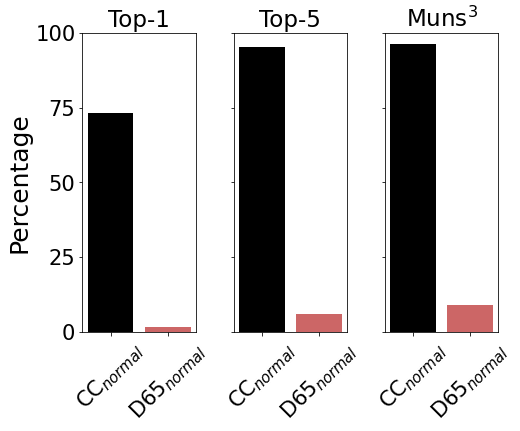

In [63]:


fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, sharey = True, figsize = (7.5,6.3))
ax1.bar([1,2],[np.mean(Accu_normal, axis = -1)[-1], np.mean(Accu_D65, axis = -1)[-1]], color = ['k',[0.8,0.4,0.4]],linewidth = 6)
ax1.set_xticks([1,2])
ax1.set_xticklabels([])
ax1.set_yticks(list(np.arange(0,105,25)))
ax1.set_ylim(0,100)
ax1.tick_params(axis='y', labelsize= 21)
ax1.set_ylabel('Percentage',fontsize = 25)
ax1.set_xticklabels(['CC$_{normal}$','D65$_{normal}$'], fontsize = 21, rotation = 45)
ax1.set_title('Top-1', fontsize = 23)


ax2.bar([1,2],[np.mean(Accu5_normal, axis = -1)[-1], 6], color = ['k',[0.8,0.4,0.4]],linewidth = 6)
ax2.set_xticks([1,2])
ax2.set_xticklabels(['CC$_{normal}$','D65$_{normal}$'], fontsize = 21, rotation = 45)
ax2.set_title('Top-5', fontsize = 23)

ax3.bar([1,2],[np.mean(Accu_munscube_normal, axis = -1)[-1], 9], color = ['k',[0.8,0.4,0.4]],linewidth = 6)
ax3.set_xticks([1,2])
ax3.set_xticklabels(['CC$_{normal}$','D65$_{normal}$'], fontsize = 21, rotation = 45)
ax3.set_title('Muns$^3$', fontsize = 23)

fig.tight_layout()
plt.show()
fig.savefig(figures_dir_path + 'Accuracies_nnp.png', dpi=800)

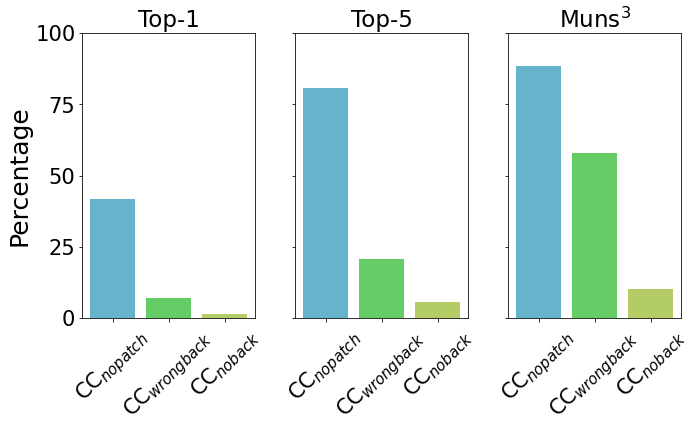

In [65]:


fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, sharey = True, figsize = (10,6.3))
ax1.bar([1,2,3],[np.mean(Accu_no_patch, axis = -1)[-1], np.mean(Accu_wrong_illu, axis = -1)[-1], 
        np.mean(Accu_no_back, axis = -1)[-1]], color = [[0.4,0.7,0.8],[0.4,0.8,0.4],[0.7,0.8,0.4]],
        linewidth = 6)
ax1.set_xticks([1,2,3])
ax1.set_xticklabels([])
ax1.set_yticks(list(np.arange(0,105,25)))
ax1.tick_params(axis='y', labelsize= 21)
ax1.set_ylabel('Percentage',fontsize = 25)
ax1.set_xticklabels(['CC$_{nopatch}$','CC$_{wrongback}$','CC$_{noback}$'], fontsize = 21, rotation = 45)
ax1.set_title('Top-1', fontsize = 23)


ax2.bar([1,2,3],[np.mean(Accu5_no_patch, axis = -1)[-1], np.mean(Accu5_wrong_illu, axis = -1)[-1], 
        np.mean(Accu5_no_back, axis = -1)[-1]], color = [[0.4,0.7,0.8],[0.4,0.8,0.4],[0.7,0.8,0.4]],
        linewidth = 6)
ax2.set_xticks([1,2,3])
ax2.set_yticks(list(np.arange(0,105,25)))
ax2.set_xticklabels(['CC$_{nopatch}$','CC$_{wrongback}$','CC$_{noback}$'], fontsize = 21, rotation = 45)
ax2.set_title('Top-5', fontsize = 23)

ax3.bar([1,2,3],[np.mean(Accu_munscube_no_patch, axis = -1)[-1], np.mean(Accu_munscube_wrong_illu, axis = -1)[-1], 
        np.mean(Accu_munscube_no_back, axis = -1)[-1]], color = [[0.4,0.7,0.8],[0.4,0.8,0.4],[0.7,0.8,0.4]],
        linewidth = 6)
ax3.set_xticks([1,2,3])
ax3.set_yticks(list(np.arange(0,105,25)))
ax3.set_ylim(0,100)
ax3.set_xticklabels(['CC$_{nopatch}$','CC$_{wrongback}$','CC$_{noback}$'], fontsize = 21, rotation = 45)
ax3.set_title('Muns$^3$', fontsize = 23)

fig.tight_layout()
plt.show()
fig.savefig(figures_dir_path + 'Accuracies_npwpnb.png', dpi=800)

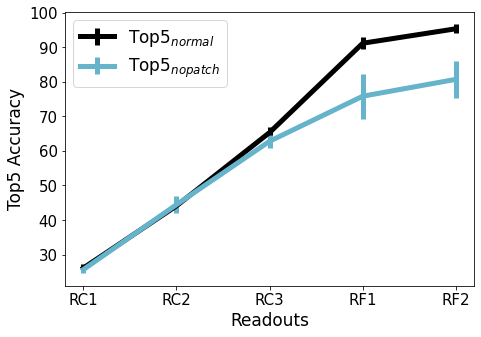

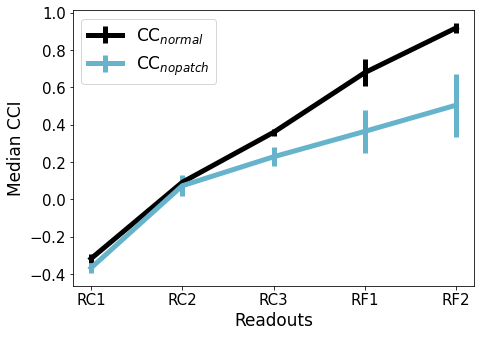

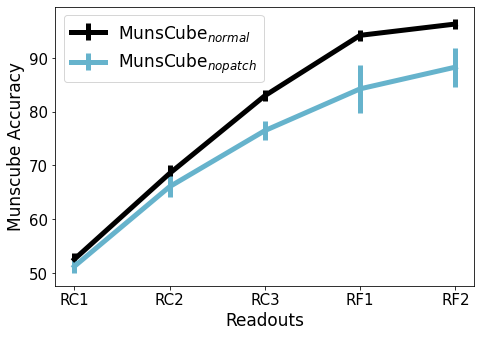

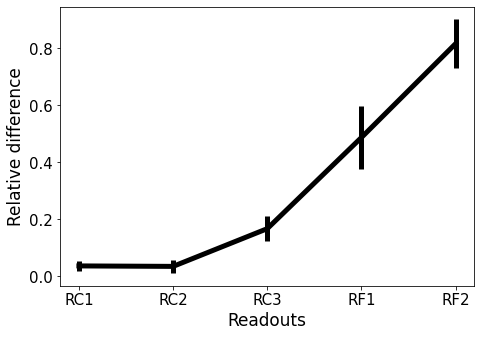

array([[-0.17533888, -0.28459658, -0.10181436, -0.0173447 , -0.12226586,
        -0.20202551, -0.16612906, -0.0936058 , -0.10782897, -0.32634487],
       [ 0.88356085,  0.25322321, -0.16122842,  0.47274299, -0.3814144 ,
         2.08679878,  0.10148249,  0.01166327, -0.18507811,  0.41751068],
       [ 0.31155397,  0.12166352,  0.47685873,  0.4886522 ,  0.425282  ,
         0.32571461,  0.37316904,  0.26771703,  0.32142085,  0.56878003],
       [ 0.5859579 ,  0.35198906,  0.34662272,  0.35560405,  0.71437736,
         0.44642282,  0.55137983,  0.29013144,  0.27992798,  0.7178323 ],
       [ 0.68727365,  0.28809903,  0.3096358 ,  0.28479499,  0.70722943,
         0.47669472,  0.59439361,  0.22062528,  0.28253123,  0.65210655]])

In [21]:

dis.DEFINE_PLT_RC(type = 1)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.errorbar([1,2,3,4,5], np.mean(Accu5_normal, axis = -1), yerr = np.std(Accu5_normal, axis = -1),
             color = 'k', label = 'Top5$_{normal}$')
ax1.errorbar([1,2,3,4,5],np.mean(Accu5_no_patch, axis = -1), yerr = np.std(Accu5_no_patch, axis = -1),
             color = [0.4,0.7,0.8], label = 'Top5$_{nopatch}$')
ax1.set_xlabel('Readouts')
ax1.set_xticks([1,2,3,4,5])
ax1.set_xticklabels(['RC1','RC2','RC3','RF1','RF2'])
ax1.set_ylabel('Top5 Accuracy')
plt.legend()
fig.tight_layout()
fig.savefig(figures_dir_path + 'Accu5_readout.png', dpi=400)
plt.show()

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.errorbar([1,2,3,4,5],np.mean(CCI_normal, axis = -1), yerr = np.std(CCI_normal, axis = -1),
             color = 'k', label = 'CC$_{normal}$')
ax1.errorbar([1,2,3,4,5],np.mean(CCI_no_patch, axis = -1), yerr = np.std(CCI_no_patch, axis = -1),
             color = [0.4,0.7,0.8], label = 'CC$_{nopatch}$')
ax1.set_xlabel('Readouts')
ax1.set_xticks([1,2,3,4,5])
ax1.set_xticklabels(['RC1','RC2','RC3','RF1','RF2'])
ax1.set_ylabel('Median CCI')
plt.legend()
fig.tight_layout()
fig.savefig(figures_dir_path + 'CCI_fost_readout.png', dpi=600)
plt.show()

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.errorbar([1,2,3,4,5], np.mean(Accu_munscube_normal, axis = -1), yerr = np.std(Accu_munscube_normal, axis = -1),
             color = 'k', label = 'MunsCube$_{normal}$')
ax1.errorbar([1,2,3,4,5],np.mean(Accu_munscube_no_patch, axis = -1), yerr = np.std(Accu_munscube_no_patch, axis = -1),
             color = [0.4,0.7,0.8], label = 'MunsCube$_{nopatch}$')
ax1.set_xlabel('Readouts')
ax1.set_xticks([1,2,3,4,5])
ax1.set_xticklabels(['RC1','RC2','RC3','RF1','RF2'])

ax1.set_ylabel('Munscube Accuracy')
plt.legend()
fig.tight_layout()
fig.savefig(figures_dir_path + 'Munscube_readout.png', dpi=400)
plt.show()


diff = np.absolute(((1 - CCI_normal) - (1 - CCI_no_patch)))/ (1 - CCI_no_patch)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.errorbar([1,2,3,4,5], np.mean(diff, axis = -1), np.std(diff, axis = -1), color = 'k', ls = '-')
ax1.set_xlabel('Readouts')
ax1.set_xticks([1,2,3,4,5])
ax1.set_xticklabels(['RC1','RC2','RC3','RF1','RF2'])
#plt.yticks(np.arange(-1,1.1,0.5),fontsize = 14)
ax1.set_ylabel('Relative difference')
fig.tight_layout()
fig.savefig(figures_dir_path + 'CCI_fost_readout_diff.png', dpi=400)
plt.show()

np.mean((CCI_normal - CCI_no_patch)/CCI_normal, axis = -1)
(CCI_normal - CCI_no_patch)/CCI_normal
